In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.simplefilter('ignore', np.RankWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0

In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:38983 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 8 Memory: 34.36 GB


In [3]:
db = '/scratch/x77/db6174/access-om2/archive/databases/cc_database_nostress_hourly.db'
session = cc.database.create_session(db)
expt = ['025deg_jra55_ryf_nostress_cont_hourly','025deg_jra55_ryf_nostress_hourly','025deg_jra55_ryf_nostress_naive']

From the [Bulk Ri analysis](https://github.com/dhruvbhagtani2105/Ryan_No_Stress/blob/master/Bulk_Richardson_Number.ipynb), it was pretty clear that the resolved (and maybe the unresolved) velocity shear contribute differently to the Richardson number for the control and no-stress runs. In this notebook, we try to estimate the Richardson number for the control case using the diagnostics only present in the no-stress case, i.e., the buoyancy frequency $N^2$ and the friction velocity $u_*$.

## 1. Finding the denominator of Richardson number

In [4]:
u_snap_con = cc.querying.getvar(expt = expt[0], session = session, variable = 'u', frequency = '1 hourly')
u_snap_buo = cc.querying.getvar(expt = expt[1], session = session, variable = 'u', frequency = '1 hourly')
u_snap_naive = cc.querying.getvar(expt = expt[2], session = session, variable = 'u', frequency = '1 hourly')

v_snap_con = cc.querying.getvar(expt = expt[0], session = session, variable = 'v', frequency = '1 hourly')
v_snap_buo = cc.querying.getvar(expt = expt[1], session = session, variable = 'v', frequency = '1 hourly')
v_snap_naive = cc.querying.getvar(expt = expt[2], session = session, variable = 'v', frequency = '1 hourly')

In [5]:
vert_coord = u_snap_con.st_ocean.values

In [6]:
Ribot_con_array = np.zeros_like((((u_snap_con))))
Ribot_buo_array = np.zeros_like((((u_snap_buo))))
Ribot_naive_array = np.zeros_like((((u_snap_naive))))

index = 0
for i in vert_coord:
    Ribot_con_array[:,index,:,:] = (((u_snap_con.sel(st_ocean = 0, method = 'nearest')) - (u_snap_con.sel(st_ocean = i, method = 'nearest')))**2 + ((
        v_snap_con.sel(st_ocean = 0, method = 'nearest')) - (v_snap_con.sel(st_ocean = i, method = 'nearest')))**2).values
    index = index + 1
       
# Creating a data-array for Ribot
Ribot_con = xr.DataArray(Ribot_con_array,  coords = [u_snap_con.time, u_snap_con.st_ocean, u_snap_con.yu_ocean, u_snap_con.xu_ocean],  
                          dims = ['time','st_ocean','yu_ocean', 'xu_ocean'], name = 'Resolved velocity shear for control run', attrs = {'m^2/s^2':''})

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [7]:
hblt_snap_con = cc.querying.getvar(expt = expt[0], session = session, variable = 'hblt', frequency = '1 hourly')
hblt_snap_buo = cc.querying.getvar(expt = expt[1], session = session, variable = 'hblt', frequency = '1 hourly')
hblt_snap_naive = cc.querying.getvar(expt = expt[2], session = session, variable = 'hblt', frequency = '1 hourly')

In [8]:
taux_snap_con = cc.querying.getvar(expt = expt[0], session = session, variable = 'tau_x', frequency = '1 hourly')
tauy_snap_con = cc.querying.getvar(expt = expt[0], session = session, variable = 'tau_y', frequency = '1 hourly')

In [9]:
rho0 = 1025
ustar_con = (((taux_snap_con**2 + tauy_snap_con**2)**0.5)/rho0)**0.5

## 2. Outputting training data to use for interpolation

In [65]:
x_val = -300
y_val = 10
hblt_snap_con.sel(xt_ocean = x_val, method = 'nearest').sel(yt_ocean = y_val, method = 'nearest').sel(
    time = slice('1900-01-01 00:00:00','1900-01-01 01:00:00')).mean('time').values

array(10.230894, dtype=float32)

In [66]:
temp1 = ustar_con.sel(xu_ocean = x_val, method = 'nearest').sel(yu_ocean = y_val, method = 'nearest').sel(
    time = slice('1900-01-01 00:00:00','1900-01-01 01:00:00')).mean('time').values

In [68]:
hkpp_temp

8.71344169245257

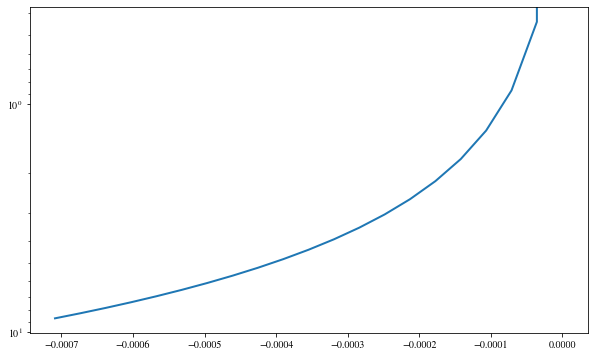

In [69]:
exp_coeff = np.log(Ribot_temp + 1)/hkpp_temp
x_array = np.linspace(0,hkpp_temp,21)

plt.figure(figsize = (10,6))
plt.yscale('log')
plt.gca().invert_yaxis()
plt.plot(np.exp(exp_coeff*x_array) - 1,x_array)

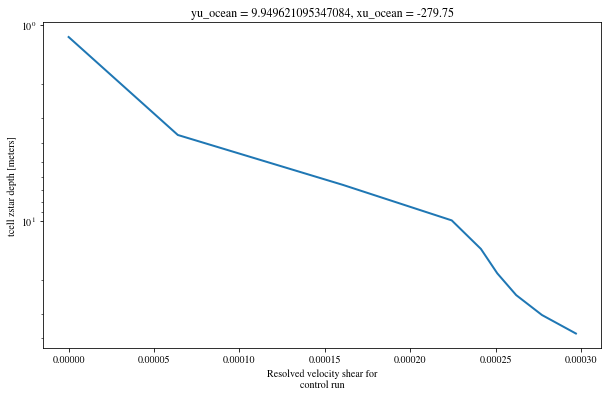

In [70]:
plt.figure(figsize = (10,6))
plt.yscale('log')
plt.gca().invert_yaxis()
Ribot_con.sel(xu_ocean = x_val, method = 'nearest').sel(yu_ocean = y_val, method = 'nearest').sel(
    time = slice('1900-01-01 00:00:00','1900-01-01 01:00:00')).mean('time').plot(y = 'st_ocean')

In [37]:
Ribot_con.sel(xu_ocean = x_val, method = 'nearest').sel(yu_ocean = y_val, method = 'nearest').sel(
    time = slice('1900-01-01 00:00:00','1900-01-01 01:00:00')).mean('time').values

array([0.        , 0.000216  , 0.00063308, 0.00101352, 0.00106293,
       0.00105978, 0.00105688, 0.00105511, 0.00105387, 0.00105892,
       0.00107852, 0.00111475, 0.00114491, 0.00115108, 0.00114788,
       0.0011419 , 0.00113295, 0.00111787, 0.001102  , 0.00108762,
       0.00107834, 0.00107769, 0.00108799, 0.00110562, 0.00111576,
       0.00112144, 0.00112734, 0.00113101, 0.00112806, 0.00112593,
       0.00112576, 0.00112202, 0.00111429, 0.00110391, 0.0010967 ,
       0.0010928 , 0.00108585, 0.00107783, 0.00107328, 0.00106825,
       0.00106117, 0.00105626, 0.00105719, 0.00106207, 0.00107331,
              nan,        nan,        nan,        nan,        nan],
      dtype=float32)

In [ ]:
plt.figure(figsize = (10,6))
plt.yscale('log')
plt.gca().invert_yaxis()
Ribot_con.sel(xu_ocean = x_val, method = 'nearest').sel(yu_ocean = y_val, method = 'nearest').sel(
    time = slice('1900-01-01 00:00:00','1900-01-01 01:00:00')).mean('time').plot(y = 'st_ocean')

## 3. Interpolating the outputted data

Text(0.5, 1.0, 'Linear interpolation of resolved velocity shear using latitude (in degrees)')

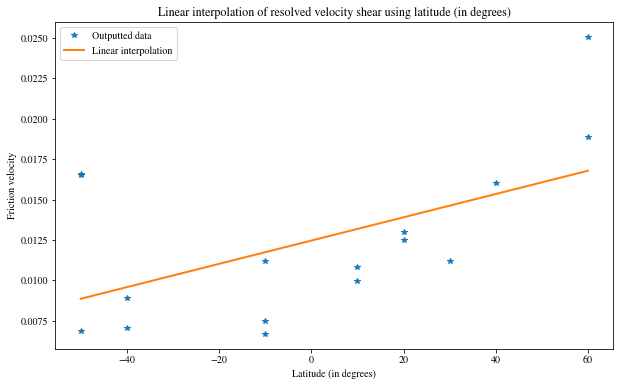

In [23]:
lat_ax = np.array([-50,-50,-50,-40,-40,-10,-10,-10,10,10,20,20,30,40,60,60])
ustar_ax = np.array([0.00687472,0.01650438,0.01657488,0.00705754,0.00892648,0.0067014,0.00747189,0.0111925,0.00995127,0.01081112,0.01250529,0.0129799,0.0111925,0.01602385,0.01887056,0.02504901])

a,b = np.polyfit(lat_ax, ustar_ax,deg = 1, rcond=None, full=False, w=None, cov=False)
plt.figure(figsize = (10,6))
plt.plot(lat_ax,ustar_ax,'*',label = 'Outputted data')
plt.plot(lat_ax,a*lat_ax + b,'-',label = 'Linear interpolation')
plt.xlabel('Latitude (in degrees)')
plt.ylabel('Friction velocity')
plt.legend()
plt.title('Linear interpolation of resolved velocity shear using latitude (in degrees)')

Text(0.5, 1.0, 'Quadratic interpolation of ustar using latitude (in degrees)')

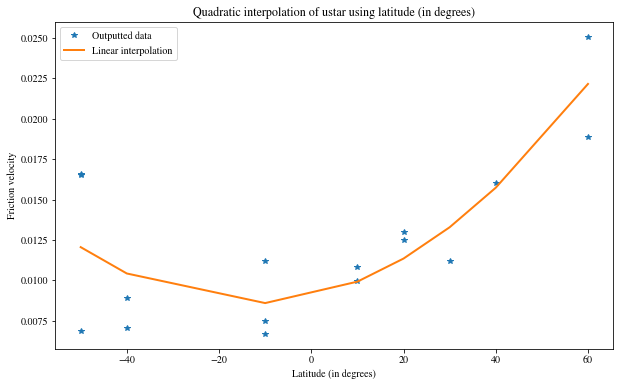

In [24]:
a,b,c = np.polyfit(lat_ax, ustar_ax,deg = 2, rcond=None, full=False, w=None, cov=False)
plt.figure(figsize = (10,6))
plt.plot(lat_ax,ustar_ax,'*',label = 'Outputted data')
plt.plot(lat_ax,a*lat_ax**2 + b*lat_ax + c,'-',label = 'Linear interpolation')
plt.xlabel('Latitude (in degrees)')
plt.ylabel('Friction velocity')
plt.legend()
plt.title('Quadratic interpolation of ustar using latitude (in degrees)')

Text(0.5, 1.0, 'Linear interpolation of resolved velocity shear using ustar')

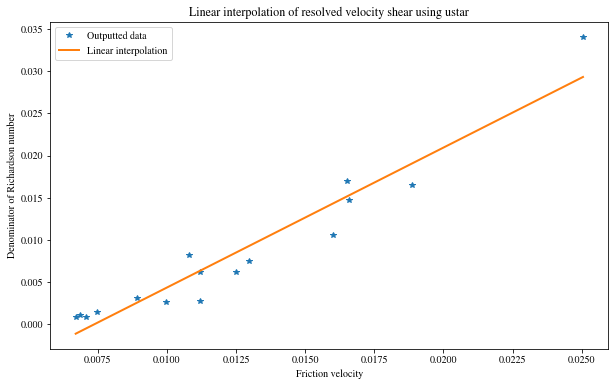

In [31]:
ustar_ax = np.array([0.0067014,0.00687472,0.00705754,0.00747189,0.00892648,0.00995127,0.01081112,0.0111925,0.0111925,0.01250529,0.0129799,0.01602385,0.01650438,0.01657488,0.01887056,0.02504901])
Ribot_ax = np.array([0.000814,0.00105,0.0008,0.0014,0.0031,0.00262,0.0082,0.0027,0.00618,0.0062,0.0075,0.01059206,0.01692,0.01467533,0.0165,0.03406804])

a,b = np.polyfit(ustar_ax, Ribot_ax, deg = 1, rcond=None, full=False, w=None, cov=False)
plt.figure(figsize = (10,6))
plt.plot(ustar_ax,Ribot_ax,'*',label = 'Outputted data')
plt.plot(ustar_ax,a*ustar_ax + b,'-',label = 'Linear interpolation')
plt.xlabel('Friction velocity')
plt.ylabel('Denominator of Richardson number')
plt.legend()
plt.title('Linear interpolation of resolved velocity shear using ustar')

Text(0.5, 1.0, 'Quadratic interpolation of resolved velocity shear using ustar')

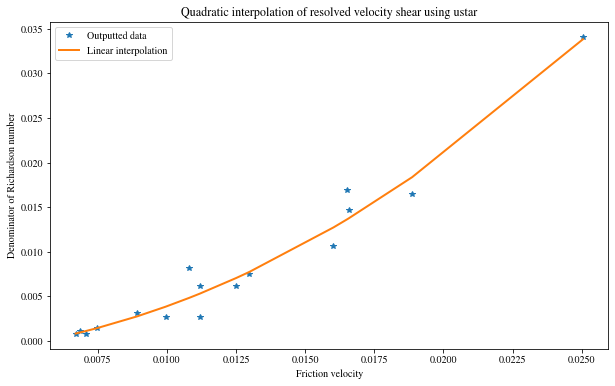

In [32]:
a1,b1,c1 = np.polyfit(ustar_ax, Ribot_ax, deg = 2, rcond=None, full=False, w=None, cov=False)
plt.figure(figsize = (10,6))
plt.plot(ustar_ax,Ribot_ax,'*',label = 'Outputted data')
plt.plot(ustar_ax,a1*ustar_ax**2 + b1*ustar_ax + c1,'-',label = 'Linear interpolation')
plt.xlabel('Friction velocity')
plt.ylabel('Denominator of Richardson number')
plt.legend()
plt.title('Quadratic interpolation of resolved velocity shear using ustar')

Text(0.5, 1.0, 'Quadratic interpolation of mixing layer height with ustar')

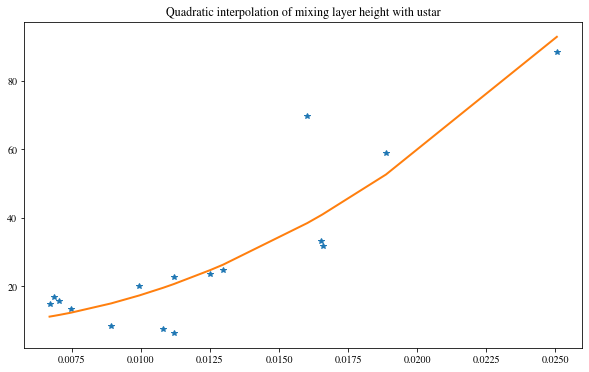

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [33]:
h_kpp_ax = [14.787515,16.887794,15.642663,13.289256,8.465828,20.148748,7.5116343,6.227066,22.82992,23.442827,24.667727,69.81167,33.357132,31.754868,58.976463,88.53869]

a2,b2,c2 = np.polyfit(ustar_ax, h_kpp_ax, deg = 2, rcond=None, full=False, w=None, cov=False)

plt.figure(figsize = (10,6))
plt.plot(ustar_ax,h_kpp_ax,'*')
plt.plot(ustar_ax, a2*ustar_ax**2 + b2*ustar_ax + c2,'-')
plt.title('Quadratic interpolation of mixing layer height with ustar')

## 4. Some random outputs

In [10]:
pot_rho_0_con = cc.querying.getvar(expt = expt[0], session = session, variable = 'pot_rho_0', frequency = '1 hourly')
pot_rho_0_buo = cc.querying.getvar(expt = expt[1], session = session, variable = 'pot_rho_0', frequency = '1 hourly')
pot_rho_0_naive = cc.querying.getvar(expt = expt[2], session = session, variable = 'pot_rho_0', frequency = '1 hourly')

In [44]:
temp_con = cc.querying.getvar(expt = expt[0], session = session, variable = 'temp', frequency = '1 hourly')
temp_buo = cc.querying.getvar(expt = expt[1], session = session, variable = 'temp', frequency = '1 hourly')
temp_naive = cc.querying.getvar(expt = expt[2], session = session, variable = 'temp', frequency = '1 hourly')

In [45]:
NN_theta_con = -(g/temp_con)*temp_con.differentiate('st_ocean')
NN_theta_buo = -(g/temp_buo)*temp_buo.differentiate('st_ocean')
NN_theta_naive = -(g/temp_naive)*temp_naive.differentiate('st_ocean')

In [12]:
g = 9.81
rho0 = 1025
NN_con = -(g/rho0)*pot_rho_0_con.differentiate('st_ocean')
NN_buo = -(g/rho0)*pot_rho_0_buo.differentiate('st_ocean')
NN_naive = -(g/rho0)*pot_rho_0_naive.differentiate('st_ocean')

In [139]:
x_val = -155
y_val = 30
NN_temp = NN_con.sel(time = slice('1900-01-01 00:00:00','1900-01-01 01:00:00')).sel(st_ocean = 1, method = 'nearest').mean('time').sel(
    xt_ocean = x_val, method = 'nearest').sel(yt_ocean = y_val, method = 'nearest').values

In [140]:
hblt_snap_con.sel(xt_ocean = x_val, method = 'nearest').sel(yt_ocean = y_val, method = 'nearest').sel(
    time = slice('1900-01-01 00:00:00','1900-01-01 01:00:00')).mean('time').values

array(34.404057, dtype=float32)

In [141]:
omega = 7.2921 * 1e-5
f = 2*omega*np.sin(np.deg2rad(y_val))

In [142]:
NN_ustar = ustar_con.sel(xu_ocean = x_val, method = 'nearest').sel(yu_ocean = y_val, method = 'nearest').sel(
    time = slice('1900-01-01 00:00:00','1900-01-01 01:00:00')).mean('time').values

In [143]:
(abs(NN_temp)**0.5 * NN_ustar)/(f**2) * (((0.04)**2)/(15))

0.6194188217640605

In [144]:
8*NN_ustar/abs(NN_temp)**0.5

35.19733553424531

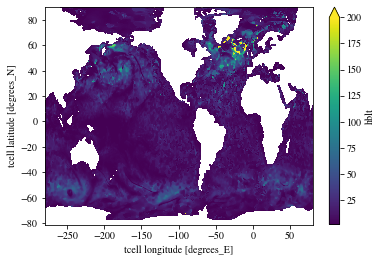

In [156]:
hblt_snap_con.sel(time = slice('1900-01-01 00:00:00','1900-01-01 01:00:00')).mean('time').plot(vmax = 200)

## 5. Finding a relationship between Ribot and ustar

Step 1: Interpolate everything to tracer grid

In [42]:
import xgcm
paths = []
paths.append("/scratch/x77/db6174/access-om2/archive/025deg_jra55_ryf_nostress_naive/output000/ocean/ocean-3d-u-1-hourly-snap-ym_1900_01.nc")

Ribot_con = Ribot_con.rename('Denominator of Richardson Number')
ustar_con = ustar_con.rename('Friction velocity')
data = xr.merge((Ribot_con,hblt_snap_con,ustar_con))
data.coords['xt_ocean'].attrs.update(axis='X')
data.coords['xu_ocean'].attrs.update(axis='X',c_grid_axis_shift=0.5)
data.coords['yt_ocean'].attrs.update(axis='Y')
data.coords['yu_ocean'].attrs.update(axis='Y',c_grid_axis_shift=0.5)
data.coords['st_ocean'].attrs.update(axis='Z')

g = xgcm.Grid(data, periodic=['X'])
u = g.interp(Ribot_con,'X')
Ribot_interp = g.interp(u,'Y',boundary="extend")

g = xgcm.Grid(data, periodic=['Y'])
v = g.interp(ustar_con,'Y')
ustar_interp = g.interp(v,'X',boundary="extend")

In [56]:
yt_ocean = cc.querying.getvar(expt = expt[0], session = session, variable = 'yt_ocean', n = 1)

In [59]:
omega = 7.2921 * 1e-5
f = 2*omega*np.sin(yt_ocean*np.pi/180)

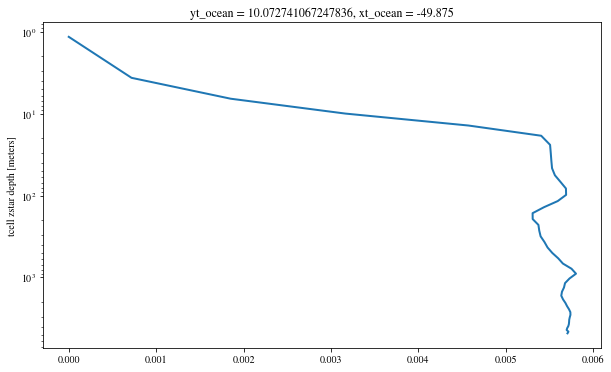

In [46]:
ustar_interp
y_val = 10

plt.figure(figsize = (10,6))
plt.yscale('log')
plt.gca().invert_yaxis()
Ribot_interp.sel(time = slice('1900-01-01 00:00:00','1900-01-01 01:00:00')).mean('time').sel(xt_ocean = x_val, method = 'nearest').sel(
    yt_ocean = y_val, method = 'nearest').plot(y = 'st_ocean')

In [31]:
hblt_snap_con.sel(time = slice('1900-01-01 00:00:00','1900-01-01 01:00:00')).mean('time').sel(xt_ocean = x_val, method = 'nearest').sel(
    yt_ocean = y_val, method = 'nearest').values

array(20.148748, dtype=float32)

In [32]:
ustar_con.sel(time = slice('1900-01-01 00:00:00','1900-01-01 01:00:00')).mean('time').sel(xu_ocean = x_val, method = 'nearest').sel(
    yu_ocean = y_val, method = 'nearest').values

array(0.00995127, dtype=float32)

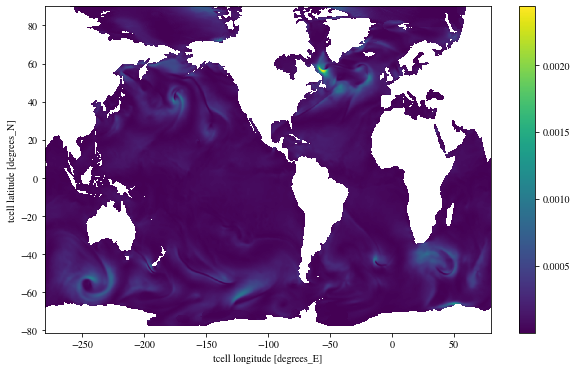

In [67]:
plt.figure(figsize = (10,6))
(ustar_interp**2 * np.exp(-f*hblt_snap_con)).sel(time = slice('1900-01-01 00:00:00','1900-01-01 01:00:00')).mean('time').plot()